### Packages loading

In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import random
import qiskit
import qtm.evolution
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.constant
from qtm.evolution import environment, mutate, selection, crossover, utils
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


## 1. Quantum architecture search for quantum state preparation problem

Now, we defind the problem which is need to solve

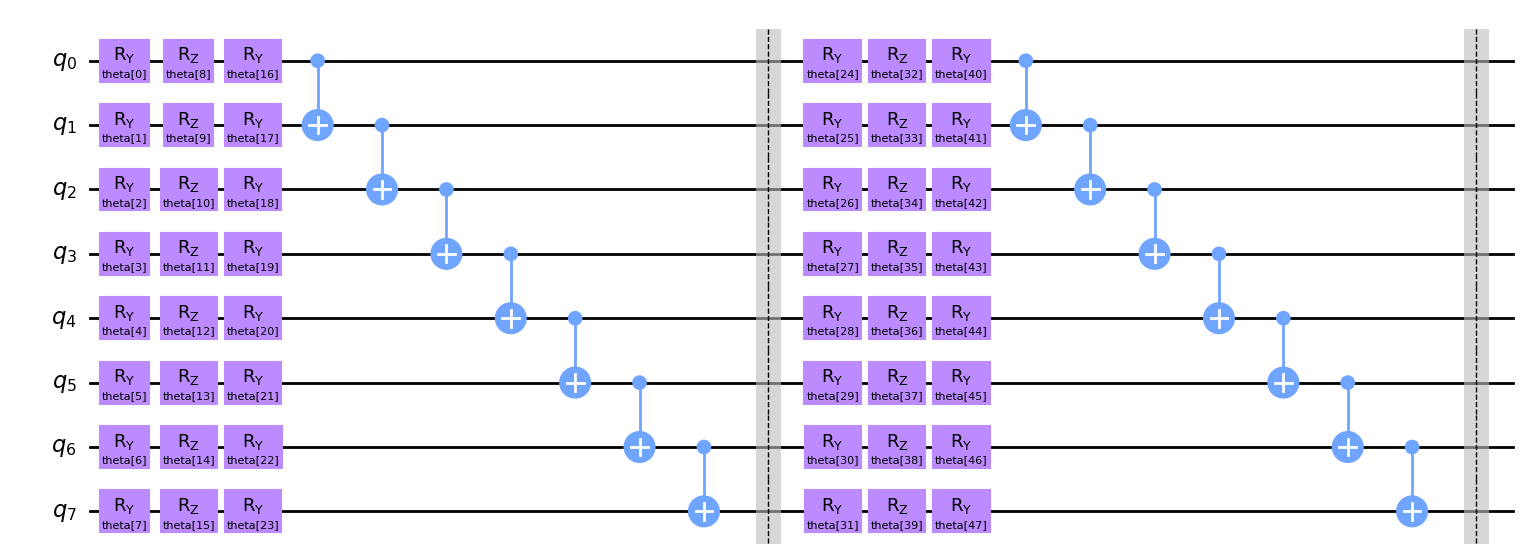

In [15]:
n_qubits=8
n=3
theta = qiskit.circuit.ParameterVector('theta',2*n*n_qubits)
#theta = np.random.rand(n*n_qubits)
#print(theta)
qc = qiskit.QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.ry(theta[i], i)
for i in range(n_qubits):
    qc.rz(theta[i+n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+2*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

for i in range(n_qubits):
    qc.ry(theta[i+3*n_qubits], i)
for i in range(n_qubits):
    qc.rz(theta[i+4*n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+5*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

qc.draw('mpl')

In [3]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals

optimizer = SLSQP(maxiter=60)
estimator = Estimator()
#algorithm_globals.random_seed = 50

driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7; H 0 0 1.4; H 0 0 2.1",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
algorithm_globals.random_seed = 50

mapper=JordanWignerMapper()
qubit_converter = QubitConverter(mapper)
qubit_op = qubit_converter.convert(hamiltonian)
vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
ene_vqe = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
print(ene_vqe)


overwrite output file: /tmp/tmpxyupp2y1.log


/tmp/ipykernel_96440/2588878265.py:27: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  qubit_converter = QubitConverter(mapper)
/home/ltnhan/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


-5.346380941899527


In [4]:

optimizers = [L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

def vqe_convergence(qc):
    for i, optimizer in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        algorithm_globals.random_seed = 50
        ansatz = qc

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, callback=store_intermediate_result)
        #vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
        #          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(qubit_op)
        print(result.eigenvalue)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)
    return converge_cnts, converge_vals

Optimizer: L_BFGS_B        -5.345983395623093
Optimizer: SLSQP        -5.346380941899527


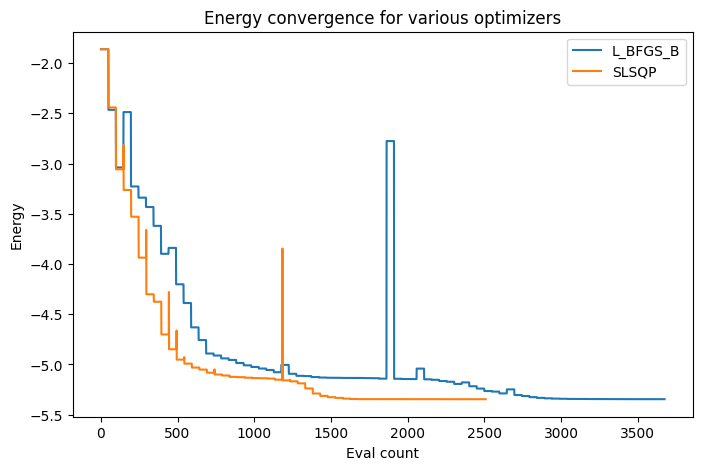

In [5]:
import pylab

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

In [6]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals


def VQE_fitness(qc: qiskit.QuantumCircuit):

    driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7; H 0 0 1.4; H 0 0 2.1",
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()

    optimizer = SLSQP(maxiter=50)
    estimator = Estimator()
    algorithm_globals.random_seed = 50
    
    mapper=JordanWignerMapper()
    qubit_converter = QubitConverter(mapper)
    qubit_op = qubit_converter.convert(hamiltonian)
    vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
    ene = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue
    print(ene)
    return ene
print(ene_vqe)
def thres(GA_eigenvalue):
    if abs(GA_eigenvalue - ene_vqe) < 0.01:
        return True
    return False


-5.346380941899527


Main algorithm, includes: init population, selection, crossover, mutate.

In [16]:
params = {'depth': 4,
          'num_circuit': 8,  # Must mod 8 = 0
          'num_generation': 10,
          'num_qubits': 8,
          'threshold': thres,
          'prob_mutate': 0.01}

env = environment.EEnvironment(
    params,
    fitness_func = VQE_fitness,
    selection_func = selection.elitist_selection,
    crossover_func= crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool = qtm.constant.operations
)

#env.initialize_population()
env.evol() 

Step:   0%|          | 0/10 [00:00<?, ?it/s]

Initialize population ...
overwrite output file: /tmp/tmpuajg1e5r.log
-4.251905852597405
overwrite output file: /tmp/tmppuva46y5.log
-4.251905852456533
overwrite output file: /tmp/tmpoe_h85q3.log
-5.129257177421222
overwrite output file: /tmp/tmpvingedpf.log
-5.129257177503767
overwrite output file: /tmp/tmp34u5tmry.log
-4.582144812705464
overwrite output file: /tmp/tmpnp6ot2vh.log
-4.582144812732038
overwrite output file: /tmp/tmpj2u9yqro.log
-3.973422107791486
overwrite output file: /tmp/tmp8eqr21zr.log
-3.9734221069889855
overwrite output file: /tmp/tmpy1n5oyzz.log
-4.016057527941025
overwrite output file: /tmp/tmpa34grgg3.log
-4.016057330177177
overwrite output file: /tmp/tmph9dk3uki.log
-3.4085836032472248
overwrite output file: /tmp/tmp28xkc4vq.log
-3.4085449140085466
overwrite output file: /tmp/tmpflucbl1r.log
-4.141878077756456
overwrite output file: /tmp/tmpgl73plxl.log
-4.14187807777427
overwrite output file: /tmp/tmpu_b1pcmt.log
-4.7185839567423375
overwrite output file: /tm

Step:  10%|█         | 1/10 [01:07<10:09, 67.74s/it]

-4.41040857707943
Evol at generation 1
Fitness -5.345055941676081, Strengh 2.483196751426837
0.5
overwrite output file: /tmp/tmp0cy11std.log
-4.36639006744867
overwrite output file: /tmp/tmpvy7u42tf.log
-5.074740085307448
Fitness -5.074740085469414, Strengh 1.663967837170127
0.5
overwrite output file: /tmp/tmpm2zp3m2y.log
-3.7409793399082343
overwrite output file: /tmp/tmpuav5ecvn.log


Step:  20%|██        | 2/10 [01:19<05:19, 39.93s/it]

-5.345055532669638
End evol progress, best score ever: -5.345055532669638


Test best candidate again

In [17]:
qc = env.best_candidate.qc
#env.plot()
print(VQE_fitness(qc))

overwrite output file: /tmp/tmpsw4nw9t6.log
-5.129257177514221
-5.129257177514221


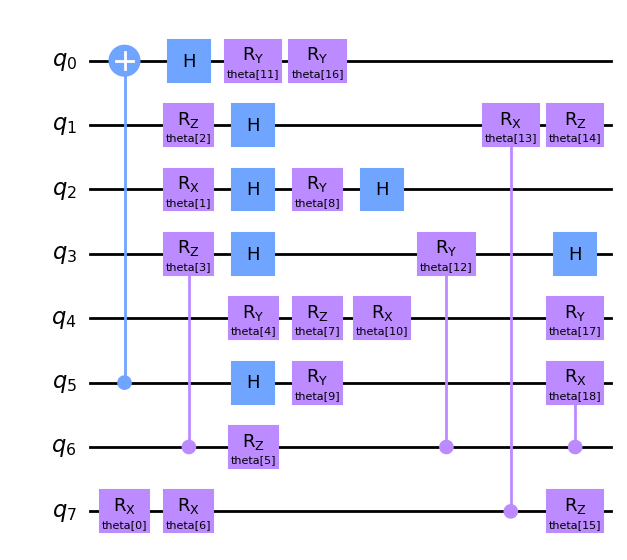

In [18]:
qc.draw('mpl')

Optimizer: L_BFGS_B        -5.129257240585812
Optimizer: SLSQP        -5.129257177413276


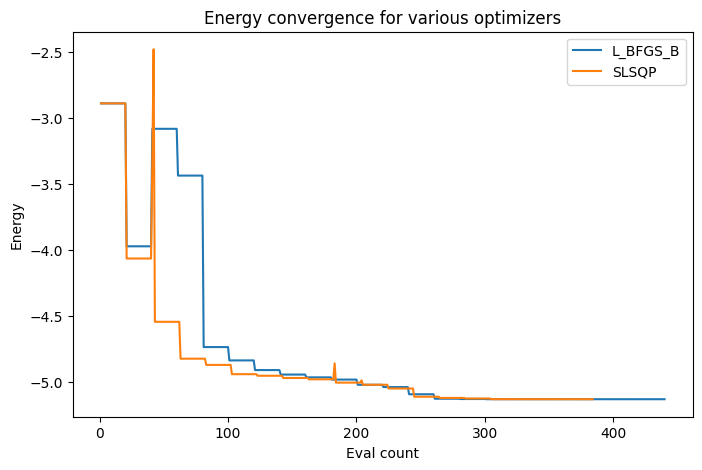

In [19]:
optimizers = [L_BFGS_B(maxiter=50), SLSQP(maxiter=50)]

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');